In [1]:
from fastai.vision.all import *
import pandas as pd

In [2]:
path = Path('data/myntradataset')

In [4]:
path.ls()

(#2) [Path('data/myntradataset/images'),Path('data/myntradataset/styles.csv')]

In [6]:
path.ls()

(#2) [Path('data/myntradataset/images'),Path('data/myntradataset/styles.csv')]

In [3]:
df = pd.read_csv('data/myntradataset/styles.csv',on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
# --- Step 2: Define a function to check if an image file exists ---
# (Make sure this function matches your get_x logic for finding the image path)
def image_file_exists(row):
    # Adjust 'images' folder name and '.jpg' extension if needed
    image_path = path / 'images' / f"{row['id']}.jpg" 
    return image_path.is_file() # is_file() checks if the path points to an existing file

# --- Step 3: Filter the DataFrame ---
print(f"Original number of rows: {len(df)}")
# Apply the function row-by-row and keep only rows where the image exists
df_filtered = df[df.apply(image_file_exists, axis=1)].copy()
print(f"Number of rows after filtering: {len(df_filtered)}")

Original number of rows: 44424
Number of rows after filtering: 44419


In [5]:
# --- Define Helper Functions ---

# Function to create the full image path from the 'id'
def get_x(row):
    # Assumes images are in an 'images' subfolder and have .jpg extension
    # Please verify the image folder name and extension in your dataset
    return path / 'images' / f"{row['id']}.jpg"

# Function to get the list of attributes (labels) from multiple columns
def get_y(row):
    # Select the columns you want to use as labels
    attribute_columns = ['gender', 'masterCategory', 'subCategory', 
                           'articleType', 'baseColour', 'season', 'usage']
    # Return the values from these columns as a list of strings
    return [str(row[col]) for col in attribute_columns]

In [8]:
get_x(df_filtered.iloc[2,:])

Path('data/myntradataset/images/59263.jpg')

In [9]:
get_y(df_filtered.iloc[2,:])

['Women', 'Accessories', 'Watches', 'Watches', 'Silver', 'Winter', 'Casual']


در حال ساخت DataLoaders با داده‌های فیلتر شده...
DataLoaders با موفقیت ساخته شد.

نمایش یک نمونه batch از داده‌های فیلتر شده:


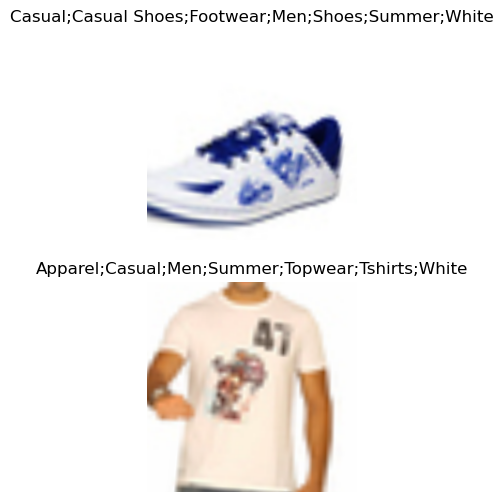

In [6]:
clothing_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_x=get_x,                             
    get_y=get_y,                             
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    item_tfms=Resize(460),                   
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), 
                Normalize.from_stats(*imagenet_stats)] 
)

# مهم: از df_filtered در اینجا استفاده کنید!
print("\nدر حال ساخت DataLoaders با داده‌های فیلتر شده...")
dls = clothing_block.dataloaders(df_filtered, bs=4) 
print("DataLoaders با موفقیت ساخته شد.")

# --- مرحله ۵: بررسی مجدد ---
print("\nنمایش یک نمونه batch از داده‌های فیلتر شده:")
dls.show_batch(nrows=2, ncols=1, max_n=2)

In [7]:
# Create the Learner
# We'll use resnet34 for now, a good starting point.
# fastai automatically selects BCEWithLogitsLoss and accuracy_multi
learn = vision_learner(dls, resnet34, metrics=accuracy_multi) 

Finding suggested learning rate...


SuggestedLRs(valley=0.002511886414140463)

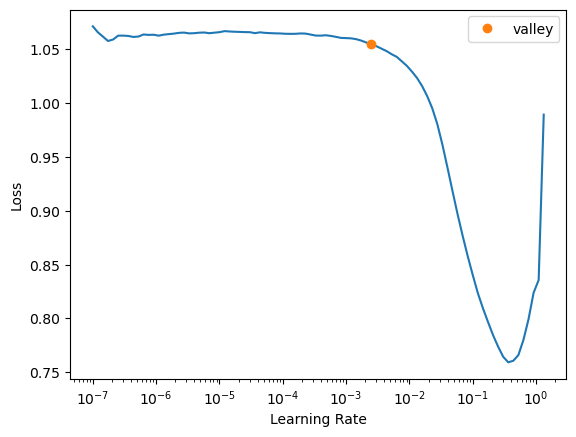

In [11]:
# Find the best learning rate
print("Finding suggested learning rate...")
learn.lr_find()

In [8]:
# Train the model using fine_tune
# Replace 1e-3 with the learning rate you found from the plot
chosen_lr = 2e-2
print(f"\nStarting training with learning rate: {chosen_lr}")
learn.fine_tune(4, base_lr=chosen_lr) # Train for 4 epochs


Starting training with learning rate: 0.02


epoch,train_loss,valid_loss,accuracy_multi,time


: 